<a href="https://colab.research.google.com/github/dvircohen0/NLP/blob/main/brown_bigrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from nltk.corpus import brown
import nltk
nltk.download('brown')
import operator
import random
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [16]:
# Define the vocabulary calss
class Vocabulary:
    def __init__(self, name):
        # import Brown corpus
        self.corpus = brown.sents()
        self.name = name
        self.smoothing = 0.1
        # we limiting the vocabulary size to save time
        self.n_vocab=2000
        self.get_sentences_with_word2idx_limit_vocab()
        self.V=len(self.word2idx_small)
        # build probabilities matrices using 3 methods: neural, logistic and simple counting
        self.neural_prob()
        self.get_bigram_probs()
        self.logistic_prob()   

    # define the softmax function    
    def softmax(self,a):
        a = a - a.max()
        exp_a = np.exp(a)
        return exp_a / exp_a.sum(axis=1, keepdims=True)


    # return the probability matrix for the counting method
    def get_bigram_probs(self,):
      # structure of bigram probability matrix will be:
      # (last word, current word) --> probability
      # we will use add-1 smoothing
      # note: we'll always ignore this from the END token
      V = len(self.word2idx_small)
      self.bigram_probs = np.ones((V, V)) * self.smoothing
      for sentence in self.sentences_small:
        for i in range(len(sentence)):
          if i == 0:
            # beginning word
            self.bigram_probs[self.start_idx, sentence[i]] += 1
          else:
            # middle word
            self.bigram_probs[sentence[i-1], sentence[i]] += 1
          # if we're at the final word
          # we update the bigram for last -> current
          # AND current -> END token
          if i == len(sentence) - 1:
            # final word
            self.bigram_probs[sentence[i], self.end_idx] += 1
    
      # normalize the counts along the rows to get probabilities
      self.bigram_probs /= self.bigram_probs.sum(axis=1, keepdims=True)


    # return the probability matrix for the neural method
    def neural_prob(self,):
        self.D = 100
        self.W1 = np.random.randn(self.V,self.D)/np.sqrt(self.V)
        self.W2 = np.random.randn(self.D,self.V)/np.sqrt(self.D)
        losses = []
        epochs = 1
        lr = 0.01
        t0 = datetime.now()
        print("Start training neural model")
        for epoch in range(epochs):
            # shuffle sentences at each epoch
            random.shuffle(self.sentences_small)
            # keep track of iterations
            j=0
            for sentence in  self.sentences_small:
                # convert sentence into one-hot encoded inputs and targets
                sentence = [self.start_idx] +sentence + [self.end_idx]
                n = len(sentence)
                inputs = sentence[:n-1]
                targets = sentence[1:]

                
                # get output predictions
                hidden = np.tanh(self.W1[inputs])
                predictions = self.softmax(hidden.dot(self.W2))
                
                # keep track of the loss
                loss = -np.sum(np.log(predictions[np.arange(n-1),targets])) / (n-1)
                losses.append(loss)
                
                doutput = predictions
                doutput[np.arange(n-1), targets] -= 1
                self.W2 = self.W2 - lr * hidden.T.dot(doutput)
                dhidden = doutput.dot(self.W2.T) * (1 - hidden * hidden)
                
                i = 0
                for w in inputs:
                    self.W1[w] = self.W1[w] - lr * dhidden[i]
                    i+=1
                
                if j % 10000 == 0:
                    print("epoch:", epoch, "sentence: %s/%s" % (j, len(self.sentences_small)),"loss:", loss)
                j +=1
        print("Training Time:", datetime.now() - t0)


    # return the probability matrix for the logistic method
    def logistic_prob(self,):
        self.W = np.random.randn(self.V,self.V)/np.sqrt(self.V)
        losses = []
        epochs = 1
        lr = 0.1
        t0 = datetime.now()
        for epoch in range(epochs):
            # shuffle sentences at each epoch
            random.shuffle(self.sentences_small)
            # keep track of iterations
            j=0
            print("Start training logistic model")
            for sentence in  self.sentences_small:
                # convert sentence into one-hot encoded inputs and targets
                sentence = [self.start_idx] +sentence + [self.end_idx]
                n = len(sentence)
                inputs = sentence[:n-1]
                targets = sentence[1:]
                # get output predictions
                predictions = self.softmax(self.W[inputs])
                # keep track of the loss
                loss = -np.sum(np.log(predictions[np.arange(n-1), targets])) / (n-1)
                losses.append(loss)
                # do a gradient descent step
                doutput = predictions
                doutput[np.arange(n-1), targets] -= 1
                i=0
                for w in inputs:
                    self.W[w] = self.W[w] - lr * doutput[i]
                    i+=1
                if j % 10000 == 0:
                    print("epoch:", epoch, "sentence: %s/%s" % (j, len(self.sentences_small)),"loss:", loss)
                j +=1
        print("Training Time:", datetime.now() - t0)
                
      
    # limiting the vocabulary size to size of n_vocab   
    def get_sentences_with_word2idx_limit_vocab(self,):
      self.indexed_sentences = []
      i = 2
      self.word2idx = {'START': 0, 'END': 1}
      self.idx2word = ['START', 'END']
      self.start_idx = self.word2idx['START']
      self.end_idx = self.word2idx['END']
    
      word_idx_count = { 0: float('inf'),1: float('inf'),}
    
      for sentence in self.corpus:
        indexed_sentence = []
        for token in sentence:
          token = token.lower()
          if token not in self.word2idx:
            self.idx2word.append(token)
            self.word2idx[token] = i
            i += 1
          # keep track of counts for later sorting
          idx = self.word2idx[token]
          word_idx_count[idx] = word_idx_count.get(idx, 0) + 1
          indexed_sentence.append(idx)
        self.indexed_sentences.append(indexed_sentence)
    
      # restrict vocab size
      self.sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
      self.word2idx_small = {}
      new_idx = 0
      idx_new_idx_map = {}
      for idx, count in self.sorted_word_idx_count[:self.n_vocab]:
        word = self.idx2word[idx]
        #print(word, count)
        self.word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
      # let 'unknown' be the last token
      self.word2idx_small['UNKNOWN'] = new_idx 
      unknown = new_idx
    
      assert('START' in self.word2idx_small)
      assert('END' in self.word2idx_small)
    
      # map old idx to new idx
      self.sentences_small = []
      for sentence in self.indexed_sentences:
        if len(sentence) > 1:
          new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
          self.sentences_small.append(new_sentence)

In [17]:
if __name__ == '__main__':
    voc=Vocabulary('bigram') 

Start training neural model
epoch: 0 sentence: 0/57013 loss: 7.610206320960348
epoch: 0 sentence: 10000/57013 loss: 4.814413764052732
epoch: 0 sentence: 20000/57013 loss: 3.8606517968287983
epoch: 0 sentence: 30000/57013 loss: 3.872916816677261
epoch: 0 sentence: 40000/57013 loss: 3.591101202400828
epoch: 0 sentence: 50000/57013 loss: 4.624814842303768
Training Time: 0:03:40.581281
Start training logistic model
epoch: 0 sentence: 0/57013 loss: 7.606447478409926
epoch: 0 sentence: 10000/57013 loss: 4.245306886556086
epoch: 0 sentence: 20000/57013 loss: 4.78476687309001
epoch: 0 sentence: 30000/57013 loss: 5.523357287164015
epoch: 0 sentence: 40000/57013 loss: 5.251396352440861
epoch: 0 sentence: 50000/57013 loss: 4.909214229407511
Training Time: 0:00:57.521610


In [18]:
    # for testing we want sentences that countains words only from the top n_vocab in the vocabulary
    test_sent=[]
    for sent in tqdm(voc.corpus):
        if set(sent).issubset(set(voc.word2idx_small.keys())) and len(sent)>10:
            test_sent.append(sent)

100%|██████████| 57340/57340 [00:07<00:00, 8124.09it/s]


In [19]:
  # saving the weights of the diffrent matrices
  
  neural_prob = np.tanh(voc.W1).dot(voc.W2)
  neural_prob.dump("bigram_neural_weights.dat")
  neural_prob = np.load("bigram_neural_weights.dat",allow_pickle=True)
    
  logistic_prob = voc.W
  logistic_prob.dump("bigram_logistic_weights.dat")
  logistic_prob = np.absolute(np.load("bigram_logistic_weights.dat",allow_pickle=True))

  count_prob = voc.bigram_probs
  count_prob.dump("bigram_count_prob.dat")
  count_prob = np.absolute(np.load("bigram_count_prob.dat",allow_pickle=True))

In [20]:
    # scoring finctions for each method
    
    def get_score_neural(sentence):
        words=sentence.lower().split()
        score = 0
        for i in range(len(words)):
          if words[i] not in voc.word2idx:
              print("Sorry, the word '",words[i],"' not in the vocabulary")
              return
          elif words[i] not in voc.word2idx_small:
              words[i] = 'UNKNOWN'
          if i == 0:
            # beginning word
            score += neural_prob[voc.start_idx, voc.word2idx_small[words[i]]]
          else:
            # middle word
            score += neural_prob[voc.word2idx_small[words[i-1]],voc.word2idx_small[words[i]]]
        # final word
        score += neural_prob[voc.word2idx_small[words[-1]], 1]
        # normalize the score
        print("SCORE is: ",score / (len(words) + 1))


    def get_score_logistic(sentence):
        words=sentence.lower().split()
        score = 0
        for i in range(len(words)):
          if words[i] not in voc.word2idx:
              print("Sorry, the word '",words[i],"' not in the vocabulary")
              return
          elif words[i] not in voc.word2idx_small:
              words[i] = 'UNKNOWN'
          if i == 0:
            # beginning word
            score += logistic_prob[voc.start_idx, voc.word2idx_small[words[i]]]
          else:
            # middle word
            score += logistic_prob[voc.word2idx_small[words[i-1]],voc.word2idx_small[words[i]]]
        # final word
        score += logistic_prob[voc.word2idx_small[words[-1]], 1]
        # normalize the score
        print("SCORE is: ",score / (len(words) + 1))

    def get_score_count(sentence):
        words=sentence.lower().split()
        score = 0
        for i in range(len(words)):
          if words[i] not in voc.word2idx:
              print("Sorry, the word '",words[i],"' not in the vocabulary")
              pass
          elif words[i] not in voc.word2idx_small:
              words[i] = 'UNKNOWN'
          if i == 0:
            # beginning word
            score += np.log(count_prob[voc.start_idx, voc.word2idx_small[words[i]]])
          else:
            # middle word
            score += np.log(count_prob[voc.word2idx_small[words[i-1]], voc.word2idx_small[words[i]]])
        # final word
        score += np.log(count_prob[voc.word2idx_small[words[-1]], voc.end_idx])
        #print thennormalize the score
        print("SCORE: ",score / (len(words) + 1) )

In [25]:
    # check real sentence from the corpus:
    sent=' '.join(random.choice(test_sent))
    print("real sentence from the corpus:",sent,"\n")
    print("For logistic model ")
    get_score_logistic(sent)
    print("For neural model ")
    get_score_neural(sent)
    print("For counting model ")
    get_score_count(sent)
    print()
    
    # check fake sentence:
    sent=random.choice(test_sent)
    fake_sent = ' '.join(random.sample(sent, len(sent)))
    print("fake sentence: ",fake_sent,"\n")
    print("For logistic model ")
    get_score_logistic(fake_sent)
    print("For neural model ")
    get_score_neural(fake_sent)
    print("For counting model ")
    get_score_count(fake_sent)

real sentence from the corpus: if we do not know how to use what we do read . 

For logistic model 
SCORE is:  4.389475981419592
For neural model 
SCORE is:  6.179564289866749
For counting model 
SCORE:  -3.8905304873720357

fake sentence:  other sufficient members the of economic condition level the presence is and social similar of . 

For logistic model 
SCORE is:  1.5592341343598497
For neural model 
SCORE is:  2.783435372416108
For counting model 
SCORE:  -7.273424685554191


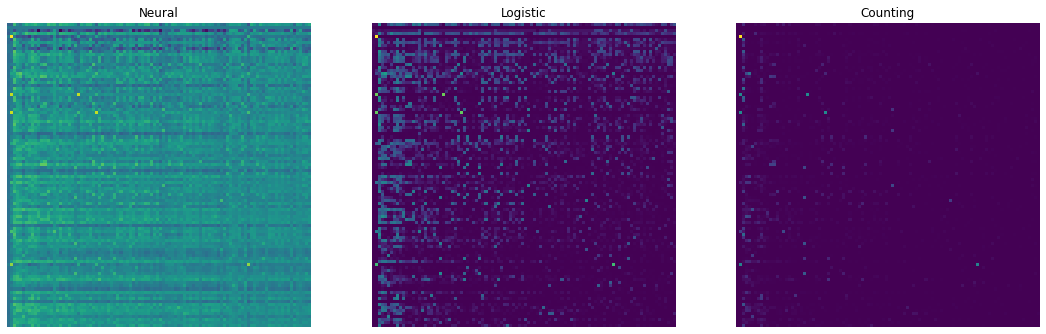

In [80]:
import matplotlib.pyplot as plt


# plotting the first 200 words probabilties
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
axs[0].imshow(neural_prob[:100,:100])
axs[0].set_title('Neural')
axs[0].axis('off')
axs[1].imshow(logistic_prob[:100,:100])
axs[1].set_title('Logistic')
axs[1].axis('off')
axs[2].imshow(count_prob[:100,:100])
axs[2].set_title('Counting')
axs[2].axis('off')
plt.show()